<a href="https://colab.research.google.com/github/pavankosana/Predicting-best-spot-for-business-in-Bangalore-/blob/main/Group14_MiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
df_bang = pd.read_excel('/content/drive/MyDrive/SMS/Bangalore Neighbourhoods.xlsx')
df_bang

,Neighbourhood,Radius
0,Domlur,793
1,Indiranagar,1053
2,Jeevanbheemanagar,547
3,Malleswaram,1121
4,Pete area,844
...,...,...
59,Nandini Layout,859
60,Nayandahalli,1024
61,Rajajinagar,1494
62,Rajarajeshwari Nagar,1931


In [ ]:
df_bang_population = pd.read_excel('/content/drive/MyDrive/SMS/Bangalore Population.xlsx')
df_bang_population

,Neighbourhood,Population
0,Domlur,31359
1,Indiranagar,71423
2,Jeevanbheemanagar,17156
3,Malleswaram,99625
4,Pete area,7119
...,...,...
59,Nandini Layout,52832
60,Nayandahalli,47999
61,Rajajinagar,227517
62,Rajarajeshwari Nagar,140262


## **Getting the Locations on Maps**

In [ ]:
!pip install geocoder

     |████████████████████████████████| 102kB 4.2MB/s 


In [ ]:
import geocoder
# Function that retrieves the geographical coordinates for a given neighborhood
def get_coordinates(row):
    # initialize variable to None
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis(f'{row["Neighbourhood"]}, Bangalore')
      lat_lng_coords = g.latlng

    # return pair lat,long
    return pd.Series([lat_lng_coords[0], lat_lng_coords[1]])

# Fill coordinates for each row
df_bang[['Latitude','Longitude']] = df_bang.apply(get_coordinates, axis=1)
df_bang.head()

,Neighbourhood,Radius,Latitude,Longitude
0,Domlur,793,12.94329,77.656020
1,Indiranagar,1053,13.03006,77.495260
2,Jeevanbheemanagar,547,12.96601,77.657670
3,Malleswaram,1121,13.00632,77.568405
4,Pete area,844,12.96618,77.586900


In [ ]:
!pip install folium

In [ ]:
import folium
# create map of Bangalore using latitude and longitude values
map_bang = folium.Map(location=[12.9716, 77.5946], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_bang['Latitude'], df_bang['Longitude'], df_bang['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bang)

map_bang

In [ ]:
CLIENT_ID = 'URSJHKAZ0KHMJ53UHYWSX5GPW4WTLZ1GEZPKQZTCY3Y10W3I'
CLIENT_SECRET = 'CDOJQD2AXNP12IT05C0LT0OM3XXJS20U2B550HZAHHTXI5ZC'
VERSION = 20211704
LIMIT = 100

In [ ]:
import requests
# Function to find venues in a given neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius):

    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['name'],
            v['location']['lat'],
            v['location']['lng'],
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                  'Neighbourhood Latitude',
                  'Neighbourhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

# Call the above function
bang_venues = getNearbyVenues(names=df_bang['Neighbourhood'],
                                   latitudes=df_bang['Latitude'],
                                   longitudes=df_bang['Longitude'],
                                   radius=df_bang['Radius'])

print(bang_venues.shape)
bang_venues

(5903, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Domlur,12.94329,77.65602,Fitness Fight Club (FFC),12.943452,77.650086,Sports Club
1,Domlur,12.94329,77.65602,SriramSpandhana Clubhouse,12.943199,77.651093,General Entertainment
2,Domlur,12.94329,77.65602,Hello Cafe/Bistro,12.946313,77.649720,Restaurant
3,Domlur,12.94329,77.65602,Shriram Spandhana,12.943231,77.651026,Residential Building (Apartment / Condo)
4,Domlur,12.94329,77.65602,IBM India Pvt. Ltd,12.950400,77.649600,Building
...,...,...,...,...,...,...,...
5898,Vijayanagar,13.07600,77.65238,Anita's Attic,13.068878,77.651591,Cultural Center
5899,Vijayanagar,13.07600,77.65238,In Vogue,13.064339,77.647870,Salon / Barbershop
5900,Vijayanagar,13.07600,77.65238,Divine Mercy Learning Centre,13.086777,77.661200,Nursery School
5901,Vijayanagar,13.07600,77.65238,Soul Valley Cafe,13.064411,77.647961,Café


In [ ]:
# one hot encoding
bang_onehot = pd.get_dummies(bang_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
bang_onehot['Neighbourhood'] = bang_venues['Neighbourhood']

# move neighbourhood column to the first column
fixed_columns = [bang_onehot.columns[-1]] + list(bang_onehot.columns[:-1])
bang_onehot = bang_onehot[fixed_columns]

# group rows by neighbourhood and find frequency of each category
bang_grouped = bang_onehot.groupby('Neighbourhood').mean().reset_index()
print(f'Size: {bang_grouped.shape}')
bang_grouped.head()

Size: (64, 412)


,Neighbourhood,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Andhra Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Bike Rental / Bike Share,Bike Shop,...,Student Center,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tech Startup,Temple,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toll Booth,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trade School,Trail,Train Station,Transportation Service,Travel Agency,Travel Lounge,Udupi Restaurant,University,Used Auto Dealership,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Warehouse,Warehouse Store,Watch Shop,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Anjanapura,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010204,0.0,0.020408,0.0,0.000000,0.000000,0.010204,0.010204,0.0,0.000000,0.0,0.010204,0.000000,0.030612,0.020408,0.010204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010204,...,0.000000,0.020408,0.0,0.0,0.0,0.0,0.0,0.010204,0.000000,0.010204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010204,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010204,0.0,0.0,0.0,0.0,0.000000
1,Arekere,0.010101,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010101,0.0,0.010101,0.000000,0.000000,0.000000,0.0,0.030303,0.0,0.000000,0.000000,0.020202,0.060606,0.020202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,...,0.010101,0.010101,0.0,0.0,0.0,0.0,0.0,0.000000,0.010101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,BTM Layout,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.010526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.021053,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.010526,0.031579,0.052632,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
3,Banashankari,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.021053,0.000000,0.000000,0.0,0.031579,0.0,0.010526,0.000000,0.021053,0.031579,0.010526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.010526,0.010526,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010526,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.010526
4,Banaswadi,0.000000,0.010526,0.0,0.0,0.0,0.0,0.0,0.021053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010526,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.021053,0.0,0.000000,0.000000,0.031579,0.094737,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010526,...,0.010526,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.031579,0.010526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.010526,0.0,0.0,0.0,0.0,0.010526,0.000000,0.0,0.0,0.0,0.0,0.000000


In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = bang_grouped['Neighbourhood']

for ind in np.arange(bang_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bang_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,Residential Building (Apartment / Condo),Housing Development,Office,Bakery,Indian Restaurant,Fast Food Restaurant,Field,South Indian Restaurant,Bank,North Indian Restaurant
1,Arekere,Indian Restaurant,Office,Bank,Residential Building (Apartment / Condo),Sporting Goods Shop,Department Store,Gas Station,Automotive Shop,Pizza Place,Coworking Space
2,BTM Layout,Indian Restaurant,Fast Food Restaurant,Bank,Park,Health & Beauty Service,Bakery,Optical Shop,Salon / Barbershop,Juice Bar,Office
3,Banashankari,Office,Building,Indian Restaurant,Hospital,Fast Food Restaurant,Ice Cream Shop,Diner,Doctor's Office,Bank,Automotive Shop
4,Banaswadi,Office,Furniture / Home Store,Bank,Residential Building (Apartment / Condo),Electronics Store,Café,Salon / Barbershop,Bus Station,Building,Bakery
5,Basavanagudi,Fast Food Restaurant,Bank,Clothing Store,Office,Hotel,Temple,Indian Restaurant,Snack Place,Dessert Shop,Kids Store
6,Basaveshwaranagar,Indian Restaurant,Fast Food Restaurant,High School,Convention Center,Medical Center,Office,Gas Station,Hotel,Ice Cream Shop,Bank
7,Begur,Residential Building (Apartment / Condo),Housing Development,Salon / Barbershop,Bank,Government Building,Indian Restaurant,South Indian Restaurant,Office,Fruit & Vegetable Store,Department Store
8,Bellandur,Residential Building (Apartment / Condo),Bank,Salon / Barbershop,Bakery,Indian Restaurant,Office,Pizza Place,Fast Food Restaurant,Café,Performing Arts Venue
9,Bommanahalli,Indian Restaurant,Factory,Building,Residential Building (Apartment / Condo),Automotive Shop,Office,Department Store,Bank,College Cafeteria,Dentist's Office


## **Doing KMeans Clustering**

1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

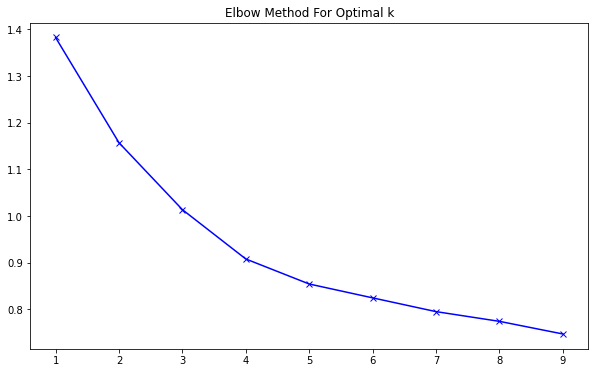

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Elbow method for clustering
bang_grouped_clustering = bang_grouped.drop('Neighbourhood', 1)
sum_of_squared_distances = []

# maximum of 10 clusters
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(bang_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [ ]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(bang_grouped_clustering)
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bang_merged = df_bang

# merge bang_grouped with df_bang to add latitude/longitude for each neighbourhood
bang_merged = bang_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

bang_merged.head()

,Neighbourhood,Radius,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Domlur,793,12.94329,77.656020,2,Office,Residential Building (Apartment / Condo),Indian Restaurant,Building,Golf Course,Military Base,Snack Place,Photography Lab,Hotel,Café
1,Indiranagar,1053,13.03006,77.495260,0,Factory,Office,Residential Building (Apartment / Condo),Automotive Shop,Housing Development,Bank,Building,Gas Station,Vegetarian / Vegan Restaurant,Convention Center
2,Jeevanbheemanagar,547,12.96601,77.657670,2,Office,Residential Building (Apartment / Condo),Indian Restaurant,Housing Development,Tech Startup,Gas Station,Chinese Restaurant,Doctor's Office,Food Truck,Department Store
3,Malleswaram,1121,13.00632,77.568405,3,Hospital,Bank,Indian Restaurant,Building,Gym / Fitness Center,Mobile Phone Shop,Tech Startup,Residential Building (Apartment / Condo),Medical Center,Business Center
4,Pete area,844,12.96618,77.586900,3,Indian Restaurant,Building,Electronics Store,Office,Bank,Government Building,General Travel,Juice Bar,Boarding House,Courthouse


In [ ]:
# Examine popular venues in Cluster 0
cul1 = bang_merged.loc[bang_merged['Cluster Labels'] == 0, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]
cul1

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Indiranagar,0,Factory,Office,Residential Building (Apartment / Condo),Automotive Shop,Housing Development,Bank,Building,Gas Station,Vegetarian / Vegan Restaurant,Convention Center
28,Peenya,0,Factory,Residential Building (Apartment / Condo),Office,College Classroom,College Auditorium,Internet Cafe,College Academic Building,Tech Startup,Convenience Store,Mobile Phone Shop
34,Bommasandra,0,Factory,Office,Indian Restaurant,Coworking Space,Hotel,Pizza Place,Residential Building (Apartment / Condo),Bus Station,Bank,Rest Area


In [ ]:
dups1 = cul1.pivot_table(index = ['1st Most Common Venue'], aggfunc ='size')
dups1

1st Most Common Venue
Factory    3
dtype: int64

In [ ]:
# Examine popular venues in Cluster 1
cul2 = bang_merged.loc[bang_merged['Cluster Labels'] == 1, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]
cul2

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Sadashivanagar,1,Office,Residential Building (Apartment / Condo),Spa,Doctor's Office,ATM,Medical School,Design Studio,Coffee Shop,Clothing Store,Building
10,Bellandur,1,Residential Building (Apartment / Condo),Bank,Salon / Barbershop,Bakery,Indian Restaurant,Office,Pizza Place,Fast Food Restaurant,Café,Performing Arts Venue
12,Hoodi,1,Indian Restaurant,Residential Building (Apartment / Condo),Salon / Barbershop,Automotive Shop,Gas Station,Housing Development,Factory,Bank,Building,Vegetarian / Vegan Restaurant
13,Krishnarajapuram,1,Indian Restaurant,Residential Building (Apartment / Condo),Automotive Shop,Gas Station,Office,Auto Dealership,Miscellaneous Shop,Fast Food Restaurant,High School,Bank
14,Mahadevapura,1,Salon / Barbershop,Residential Building (Apartment / Condo),Department Store,Bank,Indian Restaurant,Bakery,Pizza Place,Office,Vegetarian / Vegan Restaurant,Multiplex
15,Marathahalli,1,Residential Building (Apartment / Condo),Indian Restaurant,Fast Food Restaurant,Bus Station,Hotel,Snack Place,Bank,Bakery,Pizza Place,Juice Bar
16,Varthur,1,Indian Restaurant,Residential Building (Apartment / Condo),Office,Bakery,Gas Station,Bank,Clothing Store,Shopping Mall,Automotive Shop,Pizza Place
17,Whitefield,1,Bank,Residential Building (Apartment / Condo),Indian Restaurant,Hotel,Building,Bakery,Housing Development,Design Studio,Café,Salon / Barbershop
20,Horamavu,1,Residential Building (Apartment / Condo),Government Building,Salon / Barbershop,Department Store,Auto Garage,Pharmacy,Badminton Court,Indian Restaurant,Housing Development,Furniture / Home Store
21,Kalyan Nagar,1,Department Store,Residential Building (Apartment / Condo),Hospital,Gas Station,Bakery,Temple,Bank,Salon / Barbershop,Indian Restaurant,Gym


In [ ]:
dups2 = cul2.pivot_table(index = ['1st Most Common Venue'], aggfunc ='size')
dups2

1st Most Common Venue
Bank                                         1
Department Store                             1
Factory                                      2
Indian Restaurant                            5
Office                                       1
Pharmacy                                     1
Residential Building (Apartment / Condo)    10
Salon / Barbershop                           2
dtype: int64

In [ ]:
# Examine popular venues in Cluster 2
cul3 = bang_merged.loc[bang_merged['Cluster Labels'] == 2, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]
cul3

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Domlur,2,Office,Residential Building (Apartment / Condo),Indian Restaurant,Building,Golf Course,Military Base,Snack Place,Photography Lab,Hotel,Café
2,Jeevanbheemanagar,2,Office,Residential Building (Apartment / Condo),Indian Restaurant,Housing Development,Tech Startup,Gas Station,Chinese Restaurant,Doctor's Office,Food Truck,Department Store
6,Seshadripuram,2,Office,Event Space,Coworking Space,Government Building,Indian Restaurant,Café,Tech Startup,Bakery,Building,Salon / Barbershop
8,Ulsoor,2,Office,Residential Building (Apartment / Condo),Temple,Fast Food Restaurant,Café,Pharmacy,Government Building,Soccer Field,Pool,Dentist's Office
9,Vasanth Nagar,2,Office,Building,Residential Building (Apartment / Condo),Snack Place,Bank,Meeting Room,Embassy / Consulate,Coffee Shop,Restaurant,Chinese Restaurant
11,CV Raman Nagar,2,Office,Juice Bar,Coworking Space,Indian Restaurant,Fast Food Restaurant,Gas Station,Food Court,Government Building,Pizza Place,Residential Building (Apartment / Condo)
18,Banaswadi,2,Office,Furniture / Home Store,Bank,Residential Building (Apartment / Condo),Electronics Store,Café,Salon / Barbershop,Bus Station,Building,Bakery
25,Hebbal,2,Office,Hospital,Bank,Bakery,Pizza Place,Indian Restaurant,Café,Bus Station,Building,Fast Food Restaurant
32,Yeshwanthpur,2,Office,Automotive Shop,Factory,Residential Building (Apartment / Condo),College Classroom,Indian Restaurant,College Auditorium,Gas Station,Bar,Student Center
36,Electronic City,2,Office,Indian Restaurant,Tech Startup,Food Court,Coworking Space,Factory,Ice Cream Shop,College Cafeteria,Snack Place,Building


In [ ]:
dups3 = cul3.pivot_table(index = ['1st Most Common Venue'], aggfunc ='size')
dups3

1st Most Common Venue
Office    13
dtype: int64

In [ ]:
# Examine popular venues in Cluster 3
cul4 = bang_merged.loc[bang_merged['Cluster Labels'] == 3, bang_merged.columns[[0] + list(range(4, bang_merged.shape[1]))]]
cul4

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Malleswaram,3,Hospital,Bank,Indian Restaurant,Building,Gym / Fitness Center,Mobile Phone Shop,Tech Startup,Residential Building (Apartment / Condo),Medical Center,Business Center
4,Pete area,3,Indian Restaurant,Building,Electronics Store,Office,Bank,Government Building,General Travel,Juice Bar,Boarding House,Courthouse
7,Shivajinagar,3,Indian Restaurant,Automotive Shop,Miscellaneous Shop,Food Truck,Bus Station,Pet Store,Mosque,Dessert Shop,Pharmacy,Police Station
19,HBR Layout,3,Office,Indian Restaurant,Automotive Shop,ATM,Church,Tea Room,Temple,Furniture / Home Store,Liquor Store,Factory
22,Kammanahalli,3,Indian Restaurant,Mobile Phone Shop,Fast Food Restaurant,Falafel Restaurant,Dentist's Office,Bank,Department Store,Kerala Restaurant,Clothing Store,Café
27,Mathikere,3,Indian Restaurant,Fast Food Restaurant,Bakery,Bank,Hospital,Juice Bar,Mobile Phone Shop,Gym,Dentist's Office,Medical Lab
30,Vidyaranyapura,3,Bank,Indian Restaurant,Snack Place,Temple,Ice Cream Shop,Student Center,Building,Clothing Store,Office,Diner
31,Yelahanka,3,Indian Restaurant,Fast Food Restaurant,Smoke Shop,Pizza Place,American Restaurant,Bank,Miscellaneous Shop,Ice Cream Shop,Department Store,Post Office
33,Bommanahalli,3,Indian Restaurant,Factory,Building,Residential Building (Apartment / Condo),Automotive Shop,Office,Department Store,Bank,College Cafeteria,Dentist's Office
35,BTM Layout,3,Indian Restaurant,Fast Food Restaurant,Bank,Park,Health & Beauty Service,Bakery,Optical Shop,Salon / Barbershop,Juice Bar,Office


In [ ]:
dups4 = cul4.pivot_table(index = ['1st Most Common Venue'], aggfunc ='size')
dups4

1st Most Common Venue
Arcade                   1
Bank                     3
Electronics Store        1
Fast Food Restaurant     1
Gas Station              1
Hospital                 1
Indian Restaurant       12
Office                   4
Tech Startup             1
dtype: int64

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[12.9716, 77.5946], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bang_merged['Latitude'], bang_merged['Longitude'], bang_merged['Neighbourhood'], bang_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color= rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## **Data Creation**

In [ ]:
Neighbour = []
for i in range(0, 64):
  Neighbour.append(df_bang['Neighbourhood'].iloc[i])

print(len(Neighbour))

64


In [ ]:
import random
Income = []
mu = 650000
sigma = 100000

for i in range(64):
    temp = random.gauss(mu, sigma)
    Income.append(temp)
print(len(Income))

64


In [ ]:
df_bang_income = pd.DataFrame(list(zip(Neighbour, Income)),
               columns =['Neighbourhood', 'Income'])
df_bang_income

,Neighbourhood,Income
0,Domlur,442094.017029
1,Indiranagar,592249.861845
2,Jeevanbheemanagar,718874.407661
3,Malleswaram,716725.413082
4,Pete area,720215.253738
...,...,...
59,Nandini Layout,518077.001740
60,Nayandahalli,658094.303460
61,Rajajinagar,644958.544565
62,Rajarajeshwari Nagar,562052.980659


In [ ]:
df_bang_income.to_excel(r'/content/drive/MyDrive/SMS/Bangalore Income.xlsx', index = False)
df_bang_income

,Neighbourhood,Income
0,Domlur,442094.017029
1,Indiranagar,592249.861845
2,Jeevanbheemanagar,718874.407661
3,Malleswaram,716725.413082
4,Pete area,720215.253738
...,...,...
59,Nandini Layout,518077.001740
60,Nayandahalli,658094.303460
61,Rajajinagar,644958.544565
62,Rajarajeshwari Nagar,562052.980659


## **Result For Ice Cream Shop in Ressidential area for high income areas(cluster 1)**



In [ ]:
residential_cluster_id = 1
df_bang_residential = df_bang[df_bang['Neighbourhood'].isin(bang_merged.loc[bang_merged['Cluster Labels'] == residential_cluster_id, 'Neighbourhood'])]
# Category ID in Foursquare API
icecreamshop_category = '4bf58dd8d48988d1c9941735'

# Function to count the number of icecream-like venues in a given neighbourhood
def getIcecreamVenues(row):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        row['Latitude'],
        row['Longitude'],
        icecreamshop_category,
        row['Radius'],
        LIMIT)
    # make the GET request and get get length of venues
    count = len(requests.get(url).json()["response"]['venues'])

    # return count
    return pd.Series(count)

# Apply the above function on each residential neighbourhood
df_bang_residential['Number of Ice Cream Shops'] = df_bang_residential.apply(getIcecreamVenues, axis=1)
df_bang_residential

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighbourhood,Radius,Latitude,Longitude,Number of Ice Cream Shops
5,Sadashivanagar,623,13.01483,77.57771,2
10,Bellandur,2024,12.92734,77.67169,13
12,Hoodi,1086,12.99198,77.71506,2
13,Krishnarajapuram,2375,13.00039,77.68368,11
14,Mahadevapura,1522,12.99409,77.66633,4
15,Marathahalli,1473,12.95466,77.70752,12
16,Varthur,1234,12.94348,77.74703,0
17,Whitefield,2329,12.97523,77.75238,11
20,Horamavu,1074,13.03870,77.66192,0
21,Kalyan Nagar,964,12.96802,77.52114,3


In [ ]:
# Left join with income dataframe
df_bang_residential = df_bang_residential.merge(df_bang_income, how='left', on='Neighbourhood')

# Left join with population dataframe
df_bang_residential = df_bang_residential.merge(df_bang_population, how='left', on='Neighbourhood')

# Calculate how many people per one shop live in each residential neighbourhood
df_bang_residential['People per Ice Cream Shop'] = df_bang_residential.apply(lambda x: (x['Population'] // x['Number of Ice Cream Shops']) if x['Number of Ice Cream Shops'] > 0 else x['Population'], axis=1)

print(df_bang_residential.shape)
df_bang_residential

(23, 8)


,Neighbourhood,Radius,Latitude,Longitude,Number of Ice Cream Shops,Income,Population,People per Ice Cream Shop
0,Sadashivanagar,623,13.01483,77.57771,2,616735.529568,17763,8881
1,Bellandur,2024,12.92734,77.67169,13,725923.677485,109768,8443
2,Hoodi,1086,12.99198,77.71506,2,706275.902954,45494,22747
3,Krishnarajapuram,2375,13.00039,77.68368,11,581197.299520,100248,9113
4,Mahadevapura,1522,12.99409,77.66633,4,709909.389616,118348,29587
5,Marathahalli,1473,12.95466,77.70752,12,551138.926311,118091,9840
6,Varthur,1234,12.94348,77.74703,0,643185.423348,23100,23100
7,Whitefield,2329,12.97523,77.75238,11,549143.284916,186768,16978
8,Horamavu,1074,13.03870,77.66192,0,697249.531920,84612,84612
9,Kalyan Nagar,964,12.96802,77.52114,3,687000.360397,70017,23339


In [ ]:
df_bang_residential['Demand'] = df_bang_residential['Income']*df_bang_residential['People per Ice Cream Shop']/1000000
finalOne = df_bang_residential
arr = pd.DataFrame(columns=df_bang_residential.columns)
x = finalOne['Income'].mean()

for i in finalOne.index:
  if finalOne['Income'][i]  > x:
    row = finalOne.iloc[i]
    df_length = len(arr)
    arr.loc[df_length] = row
finalOne = arr.sort_values(by=['Demand'],ascending= False)
finalOne = finalOne.iloc[:3]
finalOne

,Neighbourhood,Radius,Latitude,Longitude,Number of Ice Cream Shops,Income,Population,People per Ice Cream Shop,Demand
12,Vijayanagar,1238,13.07600,77.65238,1,694649.103474,198091,198091,137603.735556
3,Horamavu,1074,13.03870,77.66192,0,697249.531920,84612,84612,58995.677395
7,Kumaraswamy Layout,975,12.89819,77.55927,0,702180.376061,71751,71751,50382.144163


In [ ]:
import folium
# create map of Bangalore using latitude and longitude values
map_bang = folium.Map(location=[12.9716, 77.5946], zoom_start=11)

# add markers to map
for lat, lng, label in zip(finalOne['Latitude'], finalOne['Longitude'], finalOne['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bang)

map_bang

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


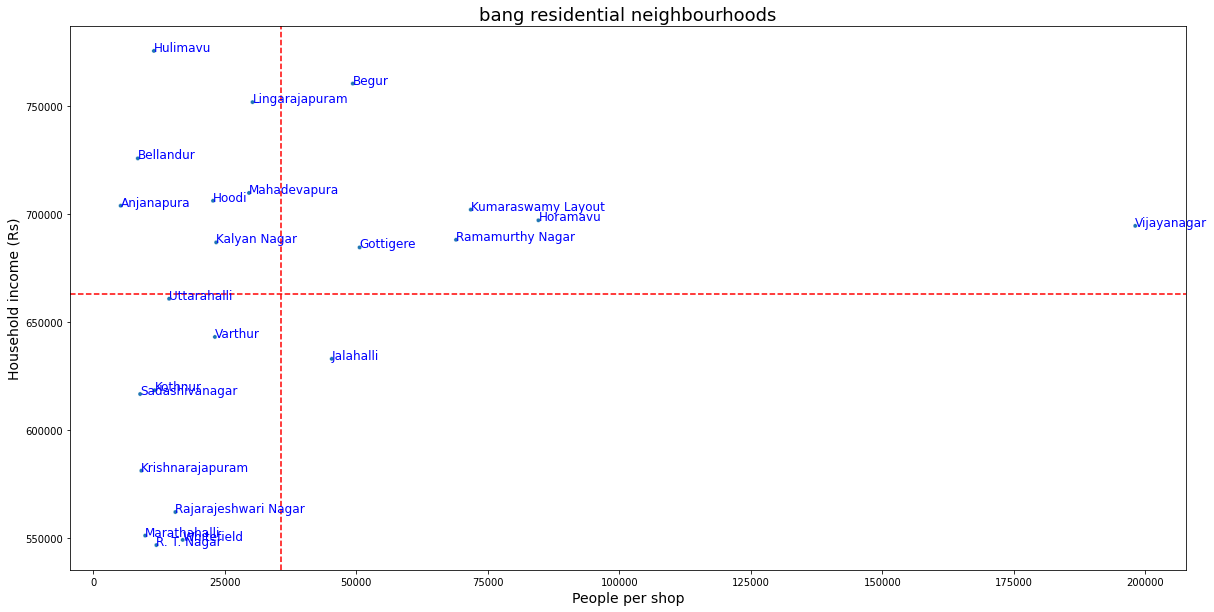

In [ ]:
import seaborn as sns
# Function to draw a scatter plot of residential neighbourhoods by household income and population per shop.
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size=8, legend=False)
    # Add text besides each point
    texts = [p1.text(data[x][line], data[y][line],
             data[text_column][line], horizontalalignment='left',
             size='large', color='blue') for line in range(0,data.shape[0])]
    #adjust_text(texts)
    # Set title and axis labels
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1

plt.figure(figsize=(20,10))

# Add horizontal and vertical lines to mark the median values
avg_people_per_shop = df_bang_residential['People per Ice Cream Shop'].mean()
max_people_per_shop = df_bang_residential['People per Ice Cream Shop'].max()
avg_income = df_bang_residential['Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_shop, color='r', linestyle='--')

# Highlight the optimal quadrant
#plt.fill_between(x=np.arange(avg_people_per_market, max_people_per_market), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People per Ice Cream Shop', 'Income', 'Neighbourhood',
             data = df_bang_residential,
             title = 'bang residential neighbourhoods',
             xlabel = 'People per shop',
             ylabel = 'Household income (Rs)')

## **Result for Gym in Residential area for low income areas(cluster 1)**

In [ ]:
residential_gym_cluster_id = 1
df_bang_residential_gym = df_bang[df_bang['Neighbourhood'].isin(bang_merged.loc[bang_merged['Cluster Labels'] == residential_gym_cluster_id, 'Neighbourhood'])]
# Category ID in Foursquare API
gym_category = '4bf58dd8d48988d176941735'

# Function to count the number of market-like venues in a given neighbourhood
def getGymVenues(row):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        row['Latitude'],
        row['Longitude'],
        gym_category,
        row['Radius'],
        LIMIT)
    # make the GET request and get get length of venues
    count = len(requests.get(url).json()["response"]['venues'])

    # return count
    return pd.Series(count)

# Apply the above function on each residential neighbourhood
df_bang_residential_gym['Number of Gyms'] = df_bang_residential_gym.apply(getGymVenues, axis=1)
df_bang_residential_gym

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighbourhood,Radius,Latitude,Longitude,Number of Gyms
5,Sadashivanagar,623,13.01483,77.57771,1
10,Bellandur,2024,12.92734,77.67169,19
12,Hoodi,1086,12.99198,77.71506,3
13,Krishnarajapuram,2375,13.00039,77.68368,27
14,Mahadevapura,1522,12.99409,77.66633,15
15,Marathahalli,1473,12.95466,77.70752,7
16,Varthur,1234,12.94348,77.74703,0
17,Whitefield,2329,12.97523,77.75238,8
20,Horamavu,1074,13.03870,77.66192,0
21,Kalyan Nagar,964,12.96802,77.52114,4


In [ ]:
# Left join with income dataframe
df_bang_residential_gym = df_bang_residential_gym.merge(df_bang_income, how='left', on='Neighbourhood')

# Left join with population dataframe
df_bang_residential_gym = df_bang_residential_gym.merge(df_bang_population, how='left', on='Neighbourhood')

# Calculate how many people per one market live in each residential neighbourhood
df_bang_residential_gym['People per Gym'] = df_bang_residential_gym.apply(lambda x: (x['Population'] // x['Number of Gyms']) if x['Number of Gyms'] > 0 else x['Population'], axis=1)

print(df_bang_residential_gym.shape)
df_bang_residential_gym

(23, 8)


,Neighbourhood,Radius,Latitude,Longitude,Number of Gyms,Income,Population,People per Gym
0,Sadashivanagar,623,13.01483,77.57771,1,616735.529568,17763,17763
1,Bellandur,2024,12.92734,77.67169,19,725923.677485,109768,5777
2,Hoodi,1086,12.99198,77.71506,3,706275.902954,45494,15164
3,Krishnarajapuram,2375,13.00039,77.68368,27,581197.299520,100248,3712
4,Mahadevapura,1522,12.99409,77.66633,15,709909.389616,118348,7889
5,Marathahalli,1473,12.95466,77.70752,7,551138.926311,118091,16870
6,Varthur,1234,12.94348,77.74703,0,643185.423348,23100,23100
7,Whitefield,2329,12.97523,77.75238,8,549143.284916,186768,23346
8,Horamavu,1074,13.03870,77.66192,0,697249.531920,84612,84612
9,Kalyan Nagar,964,12.96802,77.52114,4,687000.360397,70017,17504


In [ ]:
df_bang_residential_gym['Demand'] = df_bang_residential_gym['People per Gym']/df_bang_residential_gym['Income']
#finalTwo = df_bang_residential_gym.sort_values(by=['Demand'],ascending= False)
finalTwo = df_bang_residential_gym
arr1 = pd.DataFrame(columns=df_bang_residential_gym.columns)
x = finalTwo['Income'].mean()

for i in finalTwo.index:
  if finalTwo['Income'][i] < x:
    row = finalTwo.iloc[i]
    df_length = len(arr1)
    arr1.loc[df_length] = row
finalTwo = arr1.sort_values(by=['Demand'],ascending= False)
finalTwo = finalTwo.iloc[:3]
finalTwo

,Neighbourhood,Radius,Latitude,Longitude,Number of Gyms,Income,Population,People per Gym,Demand
5,Jalahalli,1122,13.05450,77.52658,0,633036.733483,45314,45314,0.071582
7,Uttarahalli,1342,12.89757,77.52830,0,660869.656864,28783,28783,0.043553
4,Whitefield,2329,12.97523,77.75238,8,549143.284916,186768,23346,0.042513


In [ ]:
import folium
# create map of Bangalore using latitude and longitude values
map_bang = folium.Map(location=[12.9716, 77.5946], zoom_start=11)

# add markers to map
for lat, lng, label in zip(finalTwo['Latitude'], finalTwo['Longitude'], finalTwo['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bang)

map_bang

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


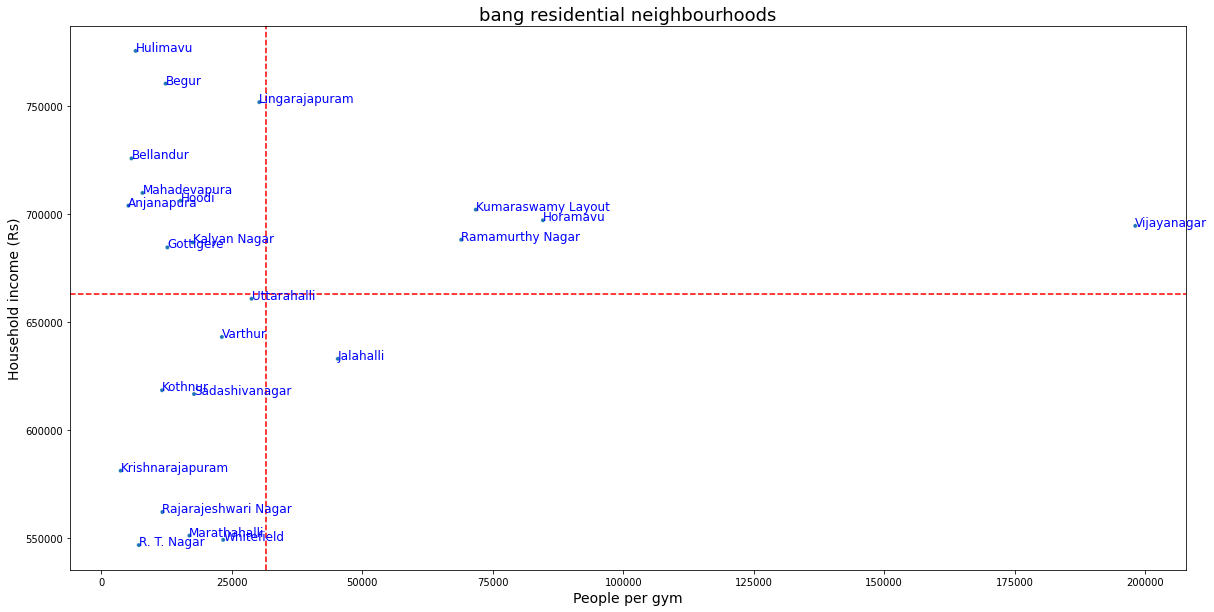

In [ ]:
import seaborn as sns
# Function to draw a scatter plot of residential neighbourhoods by household income and population per market.
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size=8, legend=False)
    # Add text besides each point
    texts = [p1.text(data[x][line], data[y][line],
             data[text_column][line], horizontalalignment='left',
             size='large', color='blue') for line in range(0,data.shape[0])]
    #adjust_text(texts)
    # Set title and axis labels
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1

plt.figure(figsize=(20,10))

# Add horizontal and vertical lines to mark the median values
avg_people_per_gym = df_bang_residential_gym['People per Gym'].mean()
max_people_per_gym = df_bang_residential_gym['People per Gym'].max()
avg_income = df_bang_residential_gym['Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_gym, color='r', linestyle='--')

# Highlight the optimal quadrant
#plt.fill_between(x=np.arange(avg_people_per_market, max_people_per_market), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People per Gym', 'Income', 'Neighbourhood',
             data = df_bang_residential_gym,
             title = 'bang residential neighbourhoods',
             xlabel = 'People per gym',
             ylabel = 'Household income (Rs)')

## **Result for Coffee Shop in Office area for high income areas(Cluster 2)**

In [ ]:
residential_coffee_cluster_id = 2
df_bang_residential_coffee = df_bang[df_bang['Neighbourhood'].isin(bang_merged.loc[bang_merged['Cluster Labels'] == residential_coffee_cluster_id, 'Neighbourhood'])]
#print(df_Bangalore_residential)
# Category ID in Foursquare API
coffee_category = '4bf58dd8d48988d16d941735'

# Function to count the number of market-like venues in a given neighbourhood
def getCoffeeVenues(row):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        row['Latitude'],
        row['Longitude'],
        coffee_category,
        row['Radius'],
        LIMIT)

    # make the GET request and get get length of venues
    count = len(requests.get(url).json()["response"]['venues'])

    # return count
    return pd.Series(count)

# Apply the above function on each residential neighbourhood
df_bang_residential_coffee['Number of Coffee'] = df_bang_residential_coffee.apply(getCoffeeVenues, axis=1)
df_bang_residential_coffee

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighbourhood,Radius,Latitude,Longitude,Number of Coffee
0,Domlur,793,12.943290,77.656020,0
2,Jeevanbheemanagar,547,12.966010,77.657670,2
6,Seshadripuram,697,12.993550,77.579880,8
8,Ulsoor,731,12.989080,77.627950,5
9,Vasanth Nagar,763,12.990730,77.588610,16
11,CV Raman Nagar,1161,12.979002,77.656132,45
18,Banaswadi,1049,13.019527,77.655028,15
25,Hebbal,990,13.049810,77.589030,7
32,Yeshwanthpur,1547,13.029550,77.540220,3
36,Electronic City,1015,12.845470,77.664300,25


In [ ]:
# Left join with income dataframe
df_bang_residential_coffee = df_bang_residential_coffee.merge(df_bang_income, how='left', on='Neighbourhood')

# Left join with population dataframe
df_bang_residential_coffee = df_bang_residential_coffee.merge(df_bang_population, how='left', on='Neighbourhood')

# Calculate how many people per one market live in each residential neighbourhood
df_bang_residential_coffee['People per Coffee'] = df_bang_residential_coffee.apply(lambda x: (x['Population'] // x['Number of Coffee']) if x['Number of Coffee'] > 0 else x['Population'], axis=1)

print(df_bang_residential_coffee.shape)
df_bang_residential_coffee

(13, 8)


,Neighbourhood,Radius,Latitude,Longitude,Number of Coffee,Income,Population,People per Coffee
0,Domlur,793,12.943290,77.656020,0,442094.017029,31359,31359
1,Jeevanbheemanagar,547,12.966010,77.657670,2,718874.407661,17156,8578
2,Seshadripuram,697,12.993550,77.579880,8,445335.198700,42558,5319
3,Ulsoor,731,12.989080,77.627950,5,524710.836645,27777,5555
4,Vasanth Nagar,763,12.990730,77.588610,16,701645.099706,42698,2668
5,CV Raman Nagar,1161,12.979002,77.656132,45,525998.543617,58034,1289
6,Banaswadi,1049,13.019527,77.655028,15,643600.700027,59267,3951
7,Hebbal,990,13.049810,77.589030,7,444753.440715,99922,14274
8,Yeshwanthpur,1547,13.029550,77.540220,3,661698.889897,154411,51470
9,Electronic City,1015,12.845470,77.664300,25,482571.603741,342299,13691


In [ ]:
df_bang_residential_coffee['Demand'] = df_bang_residential_coffee['Income']*df_bang_residential_coffee['People per Coffee']/1000000
finalThree = df_bang_residential_coffee
arr2 = pd.DataFrame(columns=df_bang_residential_coffee.columns)
x = finalThree['Income'].mean()

for i in finalThree.index:
  if finalThree['Income'][i]  > x:
    row = finalThree.iloc[i]
    df_length = len(arr2)
    arr2.loc[df_length] = row
finalThree = arr2.sort_values(by=['Demand'],ascending= False)
finalThree = finalThree.iloc[:3]
finalThree

,Neighbourhood,Radius,Latitude,Longitude,Number of Coffee,Income,Population,People per Coffee,Demand
3,Yeshwanthpur,1547,13.02955,77.54022,3,661698.889897,154411,51470,34057.641863
4,Koramangala,947,12.92004,77.62546,14,619294.875945,153187,10941,6775.705238
0,Jeevanbheemanagar,547,12.96601,77.65767,2,718874.407661,17156,8578,6166.504669


In [ ]:
import folium
# create map of Bangalore using latitude and longitude values
map_bang = folium.Map(location=[12.9716, 77.5946], zoom_start=11)

# add markers to map
for lat, lng, label in zip(finalThree['Latitude'], finalThree['Longitude'], finalThree['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bang)

map_bang

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


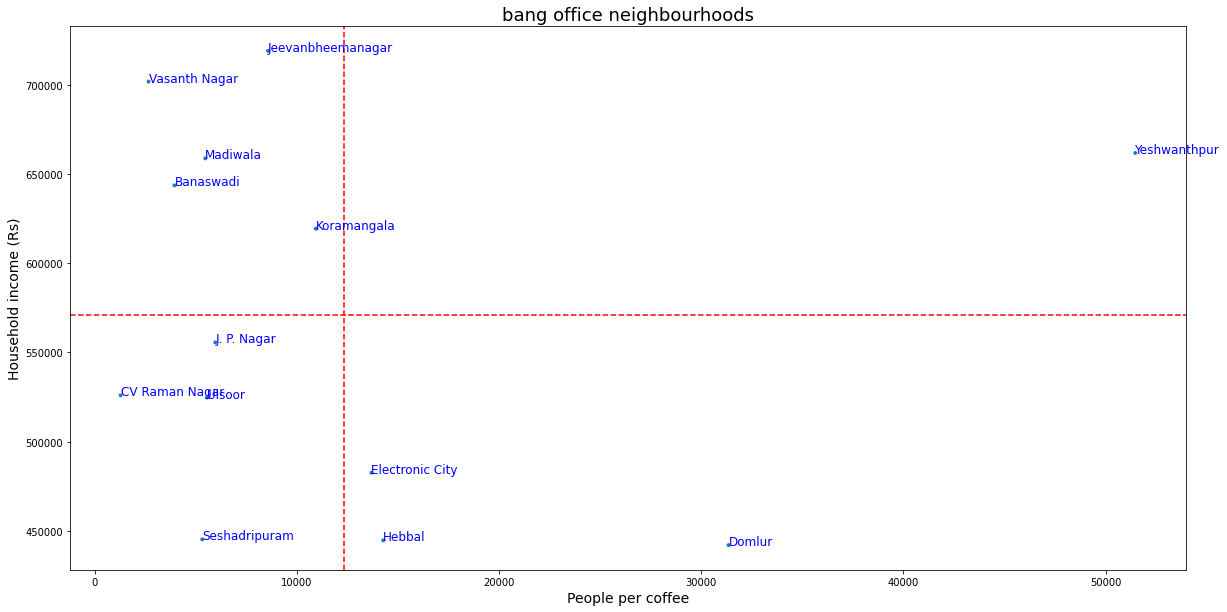

In [ ]:
import seaborn as sns
# Function to draw a scatter plot of residential neighbourhoods by household income and population per market.
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size=8, legend=False)
    # Add text besides each point
    texts = [p1.text(data[x][line], data[y][line],
             data[text_column][line], horizontalalignment='left',
             size='large', color='blue') for line in range(0,data.shape[0])]
    #adjust_text(texts)
    # Set title and axis labels
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1

plt.figure(figsize=(20,10))

# Add horizontal and vertical lines to mark the median values
avg_people_per_coffee = df_bang_residential_coffee['People per Coffee'].mean()
max_people_per_coffee = df_bang_residential_coffee['People per Coffee'].max()
avg_income = df_bang_residential_coffee['Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_coffee, color='r', linestyle='--')

# Highlight the optimal quadrant
#plt.fill_between(x=np.arange(avg_people_per_market, max_people_per_market), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People per Coffee', 'Income', 'Neighbourhood',
             data = df_bang_residential_coffee,
             title = 'bang office neighbourhoods',
             xlabel = 'People per coffee',
             ylabel = 'Household income (Rs)')

## **Result for Theater in (cluster 3) for low income area**


In [ ]:
residential_theater_cluster_id = 3
df_bang_residential_theater = df_bang[df_bang['Neighbourhood'].isin(bang_merged.loc[bang_merged['Cluster Labels'] == residential_theater_cluster_id, 'Neighbourhood'])]
#print(df_Bangalore_residential)
# Category ID in Foursquare API
theater_category = '4bf58dd8d48988d137941735'

# Function to count the number of market-like venues in a given neighbourhood
def getTheaterVenues(row):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        row['Latitude'],
        row['Longitude'],
        theater_category,
        row['Radius'],
        LIMIT)

    # make the GET request and get get length of venues
    count = len(requests.get(url).json()["response"]['venues'])

    # return count
    return pd.Series(count)

# Apply the above function on each residential neighbourhood
df_bang_residential_theater['Number of Theater'] = df_bang_residential_theater.apply(getTheaterVenues, axis=1)
df_bang_residential_theater

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighbourhood,Radius,Latitude,Longitude,Number of Theater
3,Malleswaram,1121,13.00632,77.568405,1
4,Pete area,844,12.96618,77.586900,2
7,Shivajinagar,975,12.98720,77.604010,4
19,HBR Layout,1428,13.02642,77.624370,1
22,Kammanahalli,478,13.01430,77.636850,0
27,Mathikere,303,13.03235,77.558660,0
30,Vidyaranyapura,1775,13.07927,77.559140,0
31,Yelahanka,2432,13.09931,77.592590,0
33,Bommanahalli,2260,12.90308,77.624440,0
35,BTM Layout,1375,12.91495,77.610010,0


In [ ]:
# Left join with income dataframe
df_bang_residential_theater = df_bang_residential_theater.merge(df_bang_income, how='left', on='Neighbourhood')

# Left join with population dataframe
df_bang_residential_theater = df_bang_residential_theater.merge(df_bang_population, how='left', on='Neighbourhood')

# Calculate how many people per one market live in each residential neighbourhood
df_bang_residential_theater['People per Theater'] = df_bang_residential_theater.apply(lambda x: (x['Population'] // x['Number of Theater']) if x['Number of Theater'] > 0 else x['Population'], axis=1)

print(df_bang_residential_theater.shape)
df_bang_residential_theater

(25, 8)


,Neighbourhood,Radius,Latitude,Longitude,Number of Theater,Income,Population,People per Theater
0,Malleswaram,1121,13.00632,77.568405,1,716725.413082,99625,99625
1,Pete area,844,12.96618,77.586900,2,720215.253738,7119,3559
2,Shivajinagar,975,12.98720,77.604010,4,621853.158291,84080,21020
3,HBR Layout,1428,13.02642,77.624370,1,724325.202080,100910,100910
4,Kammanahalli,478,13.01430,77.636850,0,594371.236825,23990,23990
5,Mathikere,303,13.03235,77.558660,0,622988.983116,75147,75147
6,Vidyaranyapura,1775,13.07927,77.559140,0,588961.707618,70933,70933
7,Yelahanka,2432,13.09931,77.592590,0,766826.900203,68807,68807
8,Bommanahalli,2260,12.90308,77.624440,0,732115.982859,88192,88192
9,BTM Layout,1375,12.91495,77.610010,0,478042.463756,171602,171602


In [ ]:
df_bang_residential_theater['Demand'] = df_bang_residential_theater['People per Theater']/df_bang_residential_theater['Income']
finalFour = df_bang_residential_theater
arr3 = pd.DataFrame(columns=df_bang_residential_theater.columns)
x = finalFour['Income'].mean()

for i in finalFour.index:
  if finalFour['Income'][i]  < x:
    row = finalFour.iloc[i]
    df_length = len(arr3)
    arr3.loc[df_length] = row
finalFour = arr3.sort_values(by=['Demand'],ascending= False)
finalFour = finalFour.iloc[:3]
finalFour

,Neighbourhood,Radius,Latitude,Longitude,Number of Theater,Income,Population,People per Theater,Demand
4,BTM Layout,1375,12.91495,77.61001,0,478042.463756,171602,171602,0.358968
5,HSR Layout,1785,12.91222,77.64470,0,600795.528753,176195,176195,0.293269
6,Banashankari,2045,12.92231,77.56988,2,647375.915112,361799,180899,0.279434


In [ ]:
import folium
# create map of Bangalore using latitude and longitude values
map_bang = folium.Map(location=[12.9716, 77.5946], zoom_start=11)

# add markers to map
for lat, lng, label in zip(finalFour['Latitude'], finalFour['Longitude'], finalFour['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bang)

map_bang

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


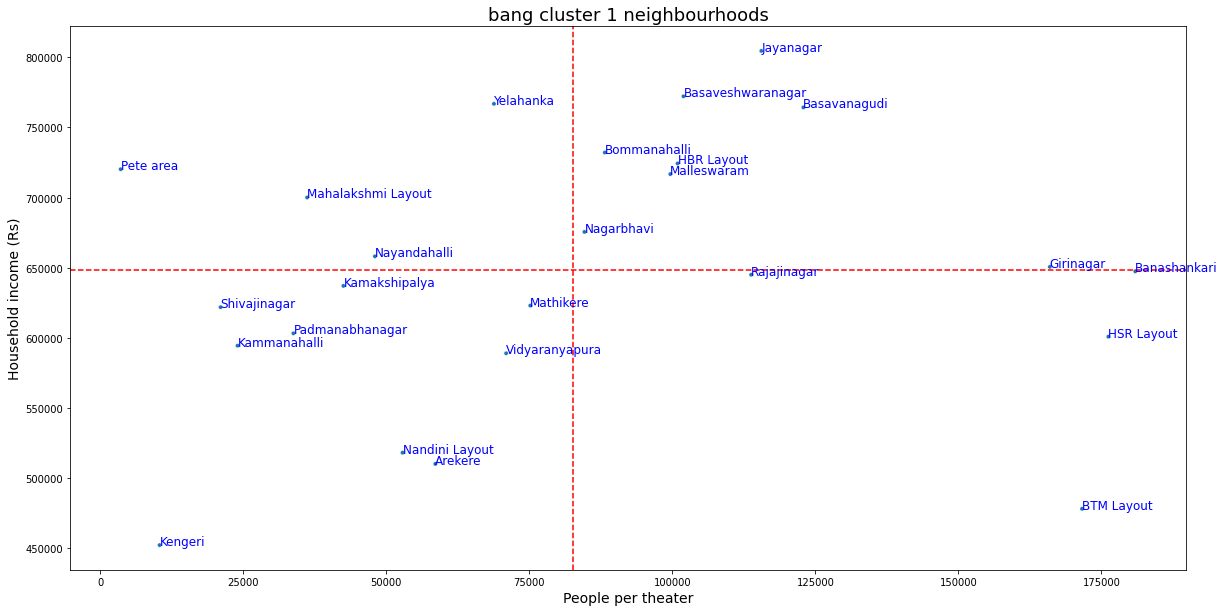

In [ ]:
import seaborn as sns
# Function to draw a scatter plot of residential neighbourhoods by household income and population per market.
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size=8, legend=False)
    # Add text besides each point
    texts = [p1.text(data[x][line], data[y][line],
             data[text_column][line], horizontalalignment='left',
             size='large', color='blue') for line in range(0,data.shape[0])]
    #adjust_text(texts)
    # Set title and axis labels
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1

plt.figure(figsize=(20,10))

# Add horizontal and vertical lines to mark the median values
avg_people_per_theater = df_bang_residential_theater['People per Theater'].mean()
max_people_per_theater = df_bang_residential_theater['People per Theater'].max()
avg_income = df_bang_residential_theater['Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_theater, color='r', linestyle='--')

# Highlight the optimal quadrant
#plt.fill_between(x=np.arange(avg_people_per_market, max_people_per_market), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People per Theater', 'Income', 'Neighbourhood',
             data = df_bang_residential_theater,
             title = 'bang cluster 1 neighbourhoods',
             xlabel = 'People per theater',
             ylabel = 'Household income (Rs)')